In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import keras
import pymystem3

from tensorflow.keras import layers
from tensorflow.keras import losses

2024-05-29 00:33:00.994963: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from pymystem3 import Mystem

In [3]:
mystem = Mystem()

In [4]:
def custom_standardization(input_data):
  s = input_data.lower()
  s = re.sub(r'http\S+', ' ', s)
  s = re.sub(r'@\S+', '', s)
  s = re.sub(r'[\W\d]', ' ', s)
  return re.sub(r'\s+', ' ', s)


In [5]:
def lemmatize(input_data):
    return " ".join(mystem.lemmatize(input_data))

In [6]:
data_pos = pd.read_csv("/home/alex/Data/datasets/RuTweetCorp/positive.csv")
data_neg = pd.read_csv("/home/alex/Data/datasets/RuTweetCorp/negative.csv")

In [7]:
data_pos.head()
data_neg.head()

,id,tdate,tname,ttext,ttype,trep,trtw,tfav,tstcount,tfoll,tfrien,listcount
0,408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,-1,0,0,0,8064,111,94,2
1,408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,0,0,0,26,42,39,0
2,408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,-1,0,0,0,718,49,249,0
3,408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",-1,0,0,0,10628,207,200,0
4,408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",-1,0,0,0,35,17,34,0


In [8]:
raw_text_pos = data_pos["ttext"]
raw_text_neg = data_neg["ttext"]

In [9]:
raw_text_pos = raw_text_pos.map(custom_standardization)
raw_text_neg = raw_text_neg.map(custom_standardization)

In [10]:
raw_text_pos = raw_text_pos.map(lemmatize)

In [11]:
raw_text_neg = raw_text_neg.map(lemmatize)

In [12]:
raw_text_np_pos = np.array(raw_text_pos)
raw_text_np_neg = np.array(raw_text_neg)

In [13]:
pos_labels = np.empty(len(raw_text_np_pos))
neg_labels = np.empty(len(raw_text_np_neg))
pos_labels[:] = 1
neg_labels[:] = 0

In [14]:
labels = np.concatenate((pos_labels, neg_labels), axis=0)

In [15]:
raw_text_np = np.concatenate((raw_text_np_pos, raw_text_np_neg), axis=0)

In [106]:
data_ds = tf.data.Dataset.from_tensor_slices((raw_text_np, labels))
data_ds = data_ds.shuffle(200000)

In [102]:
len(raw_text_np_neg)

AttributeError: 'numpy.ndarray' object has no attribute 'filter'

In [107]:
for el in data_ds.take(1000):
    print(el)

(<tf.Tensor: shape=(), dtype=string, numpy=b'\xd0\xbd\xd1\x83   \xd1\x82\xd1\x8b   \xd0\xb6\xd0\xb5   \xd0\xbe\xd0\xb1\xd0\xb5\xd1\x89\xd0\xb0\xd1\x82\xd1\x8c   \xd0\xbb\xd0\xb5\xd1\x80\xd0\xb0   \xd0\xb1\xd0\xbb\xd0\xb8\xd0\xbd   \xd0\xba\xd0\xb0\xd0\xba\xd0\xbe\xd0\xb9   \xd1\x85\xd1\x80\xd0\xb5\xd0\xbd  \n'>, <tf.Tensor: shape=(), dtype=float64, numpy=0.0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'  \xd1\x81\xd1\x83\xd0\xbf\xd0\xb5\xd1\x80   \xd0\xbd\xd0\xb0\xd1\x88   \xd0\xbd\xd0\xb5   \xd0\xbf\xd0\xbe   \xd0\xb7\xd1\x83\xd0\xb1   \xd0\xb0   \xd1\x88\xd0\xb5\xd0\xb9\xd0\xbd   \xd0\xbd\xd0\xb5\xd1\x82  \n'>, <tf.Tensor: shape=(), dtype=float64, numpy=0.0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'rt   \xd0\xb2\xd1\x81\xd0\xb5   \xd1\x81   \xd0\xb4\xd0\xb5\xd0\xbd\xd1\x8c   \xd1\x84\xd1\x83\xd1\x82\xd0\xb1\xd0\xbe\xd0\xbb   \xd1\x84\xd1\x83\xd1\x82\xd0\xb1\xd0\xbe\xd0\xbb  \n'>, <tf.Tensor: shape=(), dtype=float64, numpy=1.0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'\xd0

2024-05-29 01:59:55.215134: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [108]:
#train_ds, val_ds= keras.utils.split_dataset(data_ds, left_size=0.8, shuffle=True)
count = len(data_ds)
train_ds = data_ds.take(int(0.8*count))
test_ds = data_ds.skip(int(0.8*count))

In [51]:
train_text_ds=train_ds.map(lambda x,y: x)

In [20]:
max_features = 10000
sequence_length = 100

vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    ngrams=2,
    output_sequence_length=sequence_length)

In [21]:

vectorize_layer.adapt(train_text_ds)

2024-05-29 01:07:42.180975: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [22]:
print("1289 ---> ",vectorize_layer.get_vocabulary()[1289])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1289 --->  откуда
 313 --->  ты я
Vocabulary size: 10000


In [52]:
vectorize_layer.get_vocabulary()


['',
 '[UNK]',
 'я',
 'не',
 'и',
 'в',
 'rt',
 'на',
 'что',
 'а',
 'быть',
 'ты',
 'с',
 'как',
 'то',
 'у',
 'd',
 'это',
 'все',
 'так',
 'но',
 'он',
 'мы',
 'ну',
 'по',
 'мой',
 'за',
 'весь',
 'такой',
 'день',
 'еще',
 'хотеть',
 'уже',
 'этот',
 'да',
 'вот',
 'она',
 'же',
 'у я',
 'кто',
 'только',
 'сегодня',
 'вы',
 'о',
 'бы',
 'они',
 'мочь',
 'когда',
 'нет',
 'очень',
 'к',
 'из',
 'просто',
 'знать',
 'я не',
 'год',
 'какой',
 'один',
 'любить',
 'если',
 'от',
 'человек',
 'свой',
 'а я',
 'теперь',
 'хороший',
 'надо',
 'тоже',
 'там',
 'новый',
 'спасибо',
 'до',
 'даже',
 'хорошо',
 'завтра',
 'для',
 'тот',
 'себя',
 'самый',
 'вообще',
 'делать',
 'понимать',
 'сказать',
 'раз',
 'сейчас',
 'думать',
 'много',
 'утро',
 'который',
 'смотреть',
 'что я',
 'время',
 'говорить',
 'спать',
 'пойти',
 'идти',
 'или',
 'почему',
 'не мочь',
 'тут',
 'давать',
 'блин',
 'без',
 'друг',
 'сидеть',
 'сделать',
 'писать',
 'и не',
 'жизнь',
 'можно',
 'про',
 'всегда',


In [109]:
train_ds_2 = train_ds.map(lambda x,y:(vectorize_layer(x),y))

In [110]:
train_ds_3 = train_ds_2.batch(32)

In [111]:
test_ds_2 = test_ds.map(lambda x,y:(vectorize_layer(x),y))

In [112]:
test_ds_3 = test_ds_2.batch(32)

In [113]:
for el in test_ds_3.take(10000):
    print(el)

(<tf.Tensor: shape=(32, 100), dtype=int64, numpy=
array([[3011,    2,   32, ...,    0,    0,    0],
       [   4,  102,   17, ...,    0,    0,    0],
       [   1,  165,   69, ...,    0,    0,    0],
       ...,
       [   6,    9,   35, ...,    0,    0,    0],
       [ 974,    1,   12, ...,    0,    0,    0],
       [ 122,    1, 3267, ...,    0,    0,    0]])>, <tf.Tensor: shape=(32,), dtype=float64, numpy=
array([0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0.,
       0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1.])>)
(<tf.Tensor: shape=(32, 100), dtype=int64, numpy=
array([[ 618,  860,   23, ...,    0,    0,    0],
       [1075,    2,   95, ...,    0,    0,    0],
       [ 284,    3,   85, ...,    0,    0,    0],
       ...,
       [  27,  391, 1019, ...,    0,    0,    0],
       [   6,  103,   70, ...,    0,    0,    0],
       [ 650,  311,  179, ...,    0,    0,    0]])>, <tf.Tensor: shape=(32,), dtype=float64, numpy=
array([1., 1., 1., 1., 1., 0., 

In [124]:
embedding_dim=32

model = tf.keras.Sequential([
  tf.keras.Input(shape=(None,), dtype=tf.int32),
  layers.Embedding(
    max_features, 
    embedding_dim,
    embeddings_initializer="uniform",
  ),  
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(12, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, None, 32)       │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │           396 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,409 (1.22 MB)

 Trainable params: 320,409 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [125]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

In [126]:
epochs = 10
history = model.fit(
    train_ds_3,
    validation_data=test_ds_3,
    epochs=epochs)

Epoch 1/10
5671/5671 ━━━━━━━━━━━━━━━━━━━━ 82s 14ms/step - binary_accuracy: 0.6281 - loss: 0.6281 - val_binary_accuracy: 0.7535 - val_loss: 0.4911
Epoch 2/10
5671/5671 ━━━━━━━━━━━━━━━━━━━━ 93s 16ms/step - binary_accuracy: 0.7513 - loss: 0.4960 - val_binary_accuracy: 0.7603 - val_loss: 0.4789
Epoch 3/10
5671/5671 ━━━━━━━━━━━━━━━━━━━━ 97s 17ms/step - binary_accuracy: 0.7653 - loss: 0.4766 - val_binary_accuracy: 0.7870 - val_loss: 0.4500
Epoch 4/10
5671/5671 ━━━━━━━━━━━━━━━━━━━━ 88s 15ms/step - binary_accuracy: 0.7717 - loss: 0.4674 - val_binary_accuracy: 0.7374 - val_loss: 0.5055
Epoch 5/10
5671/5671 ━━━━━━━━━━━━━━━━━━━━ 85s 15ms/step - binary_accuracy: 0.7738 - loss: 0.4621 - val_binary_accuracy: 0.7468 - val_loss: 0.4937
Epoch 6/10
5671/5671 ━━━━━━━━━━━━━━━━━━━━ 96s 17ms/step - binary_accuracy: 0.7758 - loss: 0.4598 - val_binary_accuracy: 0.7931 - val_loss: 0.4383
Epoch 7/10
5671/5671 ━━━━━━━━━━━━━━━━━━━━ 95s 17ms/step - binary_accuracy: 0.7779 - loss: 0.4554 - val_binary_accuracy: 0.77

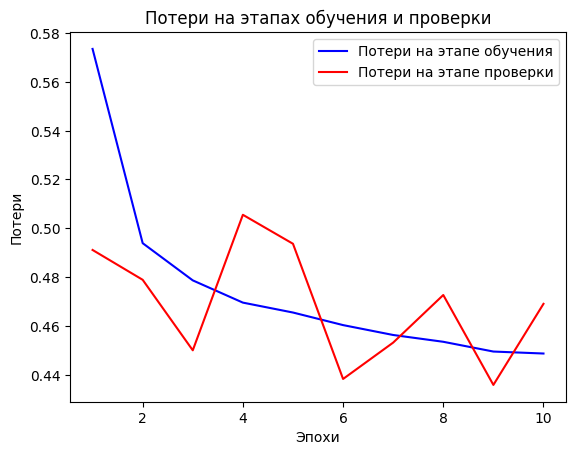

In [129]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "b", label="Потери на этапе обучения")
plt.plot(epochs, val_loss_values, "r", label="Потери на этапе проверки")
plt.title("Потери на этапах обучения и проверки")
plt.xlabel("Эпохи")
plt.ylabel("Потери")
plt.legend()
plt.show()

In [128]:
model.predict(test_ds_3)

1418/1418 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step


array([[0.5772266 ],
       [0.89381725],
       [0.6520719 ],
       ...,
       [0.41318482],
       [0.8575708 ],
       [0.03063612]], dtype=float32)

In [35]:
n=110003
for r intrain_ds_3:
    r


TypeError: '_MapDataset' object is not subscriptable

In [294]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

export_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_7            │ ?                      │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ ?                      │       160,033 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,033 (625.13 KB)

 Trainable params: 160,033 (625.13 KB)

 Non-trainable params: 0 (0.00 B)

In [305]:
export_model.predict(tf.data.Dataset.from_tensor_slices([[
    lemmatize(custom_standardization(''))
]]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


array([[0.53059304]], dtype=float32)